In [1]:
import matplotlib.pyplot as plt
import imgviz
import os
from PIL import Image
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from typing import Callable
from datasets import load_dataset
from transformers import AutoProcessor
import os
import requests
from PIL import Image
import random
import regex as re
import torch

from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from torchvision.ops import box_iou
import tqdm

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def get_device(is_ddp):
    if is_ddp:
        local_rank = int(os.environ["LOCAL_RANK"])
        device = torch.device("cuda:{}".format(local_rank))
        return device
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return device
def get_rank_size(is_ddp: bool):
    if is_ddp:
        local_rank = int(os.environ["LOCAL_RANK"])
        world_rank = int(os.environ["RANK"])  # dist.get_rank()
        world_size = int(os.environ["WORLD_SIZE"])
        return local_rank, world_rank, world_size
    else:
        return 0, 0, 1

def get_dataloader(
    is_ddp: bool,
    dataset: Dataset,
    shuffle: bool,
    loader_drop_last: bool,
    batch_size: int,
    num_workers: int,
    collate_fn: Callable,
    pin_memory: bool = None,
    world_size: int = None,
    world_rank: int = None,
    seed: int = None,
    sampler_drop_last: bool | None = None,
):
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(seed)

    if is_ddp:
        sampler = torch.utils.data.distributed.DistributedSampler(
            dataset, num_replicas=world_size, rank=world_rank, shuffle=shuffle, drop_last=sampler_drop_last, seed=seed
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            drop_last=loader_drop_last,
            sampler=sampler,
            worker_init_fn=seed_worker,
            generator=g,
        )
    else:
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            shuffle=shuffle,
            drop_last=loader_drop_last,
            worker_init_fn=seed_worker,
            generator=g,
        )
        
class RefCOCODataset(Dataset):
    def __init__(self, dataset, image_folder_root):
        self.dataset = dataset
        self.image_folder_root = image_folder_root

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        raw_image_info = json.loads(sample["raw_image_info"])
        image_file_name = raw_image_info["file_name"]
        original_image_width_height = (raw_image_info["width"], raw_image_info["height"])
        image_path = os.path.join(self.image_folder_root,image_file_name)
        image = Image.open(image_path).convert("RGB")
        bbox = sample["bbox"]
        caption_list = [sentences["raw"] for sentences in sample["sentences"]]
        
        return image, caption_list, bbox,original_image_width_height,image_file_name
    
def eval_collate_fn(batch):
    caption_list = []
    image_list = []
    bbox_list = []
    original_image_width_height_list = []
    image_file_name_list = []
    for image, caption, bbox, original_image_width_height, image_file_name in batch:
        image_list.append(image)
        caption_list.append(caption)
        bbox_list.append(bbox)
        original_image_width_height_list.append(original_image_width_height)
        image_file_name_list.append(image_file_name)
        
    return image_list, caption_list, bbox_list, original_image_width_height_list,image_file_name_list

def fix_seed(seed: int) -> None:
    """
    seedをする

    Args:
        seed (int): seed値
    """
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)  # cpuとcudaも同時に固定
    torch.cuda.manual_seed(seed)  # 上記で呼び出される
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
    
def qwen_vl_conversation(caption,image):
    conversation = [
        {
            "role": "user",
            "content": [

                # {"type": "text", "text": "Please output bbox coordinates and names of every object in this image in JSON format"},
                {"type": "text", "text": f"Locate \"{caption}\", report the bbox coordinates in JSON format."},
                {
                    "type": "image",
                    "image": image,
                },
            ],
        }
    ]
    return conversation

def make_inputs(caption_list,image_list,processor):
    conversation_list = []
    prompt_list = []
    for caption,image in zip(caption_list,image_list):
        conversation = qwen_vl_conversation(caption,image)
        conversation_list.append(conversation)
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
        prompt_list.append(prompt)
        
    image_inputs, video_inputs = process_vision_info(conversation_list)
    inputs = processor(
        text=prompt_list,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    model_image_width_height_list = []
    for image in image_inputs:
        model_image_width_height = (image.size[0], image.size[1])
        model_image_width_height_list.append(model_image_width_height)
    return inputs, model_image_width_height_list


def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[((\d+,\s*){3}(\d+\s*))\]')
    match_list = pattern.findall(ans)
    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox

def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def get_bbox_from_output(output_text, model_image_width_height):
    absolute_bbox = extract_bbox_from_text(output_text)
    if absolute_bbox == "FAILED":
        return False
    else:
        absolute_bbox = absolute_bbox[0]
        relative_bbox = bbox_absolute_to_relative(absolute_bbox, model_image_width_height)
        return relative_bbox

def calculate_iou(bbox1, bbox2):
    """
    Calculate IoU for two lists of bounding boxes.

    Args:
        bbox_list1 (list): List of bounding boxes in the format [x1, y1, x2, y2].
        bbox_list2 (list): List of bounding boxes in the format [x1, y1, x2, y2].

    Returns:
        torch.Tensor: IoU matrix where each element (i, j) represents the IoU between bbox_list1[i] and bbox_list2[j].
    """
    iou_matrix = box_iou(torch.tensor([bbox1]).float(), torch.tensor([bbox2]).float())
    iou_list = iou_matrix.diagonal().tolist()
    return iou_list[0]

def create_jsonl_file(file_path):
    """
    Create an empty JSONL file.

    Args:
        file_path (str): Path to the JSONL file.
    """
    with open(file_path, 'w') as f:
        pass

def append_to_jsonl(file_path, data):
    """
    Append a dictionary as a JSON object to a JSONL file.

    Args:
        file_path (str): Path to the JSONL file.
        data (dict): Dictionary to append as a JSON object.
    """
    with open(file_path, 'a') as f:
        json.dump(data, f)
        f.write('\n')

def save_json(file_path, data):
    """
    Save data to a JSON file.

    Args:
        file_path (str): Path to the JSON file.
        data (dict): Data to save.
    """
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)
        
    
def calculate_accuracy(iou, threshold=0.5):
    """
    Calculate accuracy based on IoU threshold.

    Args:
        iou (float): IoU value.
        threshold (float): IoU threshold for accuracy.

    Returns:
        bool: True if IoU is greater than or equal to the threshold, False otherwise.
    """
    return iou >= threshold

In [13]:
dataset_key = "validation"  # "test" or "testB"
fix_seed(0)
device = get_device(is_ddp=False)

model_root_dir = "/home/omote/local-share-data_ssd/huggingface_model_weights"
model_id = os.path.join(model_root_dir, "Qwen/Qwen2.5-VL-7B-Instruct")
cache_dir = "/home/omote/local-share-data_ssd/huggingface_cache"

processor = AutoProcessor.from_pretrained(model_id, cache_dir=cache_dir)
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, cache_dir=cache_dir, torch_dtype=torch.bfloat16
)

model.to(device)
model.eval()

dataset_root_dir = "/home/omote/local-share-data_ssd/huggingface_dataset"
image_folder_root = "/home/omote/local-share-data/mscoco2014/train2014"


dataset_id = os.path.join(dataset_root_dir,"jxu124/refcoco")
dataset = load_dataset(dataset_id, cache_dir=cache_dir)


eval_dataset_key = ["validation","test","testB"]
eval_dataset_dict = {k: RefCOCODataset(dataset[k],image_folder_root) for k in eval_dataset_key}

eval_dataset = eval_dataset_dict[dataset_key]
eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=16,
        num_workers=0,
        pin_memory=False,
        collate_fn=eval_collate_fn,
        shuffle=False,
        drop_last=False,
)


Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 27.13it/s]


In [15]:
model_output_jsonl_path = os.path.join("./",f"qwen_vl_refcoco_{dataset_key}.jsonl")
score_json_path = os.path.join("./",f"qwen_vl_refcoco_score_{dataset_key}.json")
create_jsonl_file(model_output_jsonl_path)

iou_list = []
accuracy_list = []
for image_list, caption_list, bbox_list, original_image_width_height_list,image_file_name_list in tqdm.tqdm(eval_dataloader):
    caption_list = [caption[0] for caption in caption_list]
    inputs,model_image_width_height_list = make_inputs(caption_list,image_list,processor)
    inputs = inputs.to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=400, do_sample=False,temperature=0)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    generated_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=False,)
    
    model_bbox_list = []
    gt_bbox_list = []
    for i in range(len(image_file_name_list)):
        model_bbox = get_bbox_from_output(generated_text[i],model_image_width_height_list[i])
        model_bbox_list.append(model_bbox)
        gt_bbox = bbox_absolute_to_relative(bbox_list[i], original_image_width_height_list[i])
        gt_bbox_list.append(gt_bbox)
        if model_bbox == False:
            iou = 0.0
        else:        
            print(model_bbox, gt_bbox)
            print(model_image_width_height_list[i], original_image_width_height_list[i])
            iou = calculate_iou(model_bbox, gt_bbox)
            
        accuracy = calculate_accuracy(iou, threshold=0.5)
        image_file_name = image_file_name_list[i]
        caption = caption_list[i]
        
        data = {
            "image_file_name": image_file_name,
            "caption": caption,
            "bbox": gt_bbox,
            "model_bbox": model_bbox,
            "iou": iou,
            "accuracy": accuracy
        }
        
        append_to_jsonl(model_output_jsonl_path, data)
        iou_list.append(iou)
        accuracy_list.append(accuracy)
    break
mean_iou = np.mean(iou_list)
print(f"Mean IoU: {mean_iou}")

mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy: {mean_accuracy}")

  0%|          | 0/239 [00:00<?, ?it/s]/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|          | 0/239 [00:05<?, ?it/s]

[0.18167701863354038, 0.6386554621848739, 0.4580745341614907, 1.0] [0.18409375, 0.6247193347193347, 0.4576874999999999, 1.0]
(644, 476) (640, 481)
[0.4673913043478261, 0.22899159663865545, 0.8944099378881988, 1.0] [0.452625, 0.2292099792099792, 0.9069375000000001, 0.9887733887733888]
(644, 476) (640, 481)
[0.35, 0.27639751552795033, 0.8928571428571429, 0.9456521739130435] [0.3552693208430913, 0.27160937500000004, 0.8659953161592505, 0.9506249999999999]
(420, 644) (427, 640)
[0.3761904761904762, 0.39751552795031053, 0.6642857142857143, 0.6940993788819876] [0.3747072599531616, 0.38490625, 0.6344028103044497, 0.761140625]
(420, 644) (427, 640)
[0.0, 0.07380952380952381, 0.5031055900621118, 0.8476190476190476] [0.0, 0.07379391100702576, 0.497640625, 0.8816393442622951]
(644, 420) (640, 427)
[0.5769230769230769, 0.025793650793650792, 0.9478021978021978, 0.49404761904761907] [0.5738709677419355, 0.0128, 0.9454032258064516, 0.45998]
(364, 504) (372, 500)
[0.08241758241758242, 0.57738095238095

In [19]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
def visualize_bbox(image, bbox, caption,original_image_width_height):
    if original_image_width_height:
        width, height = original_image_width_height
        bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
        bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    else:
        bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()
    

model_bbox_list[i] == False


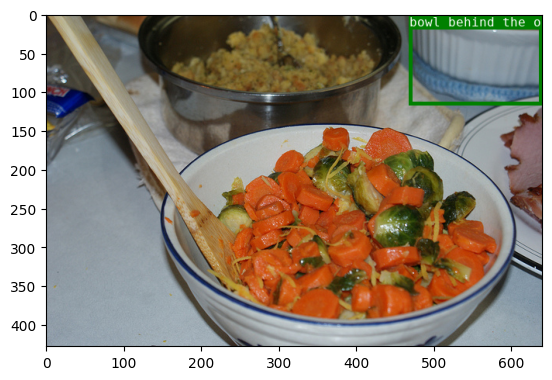

model_bbox_list[i] == False


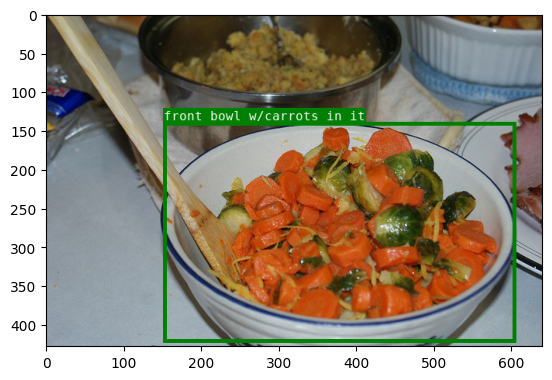

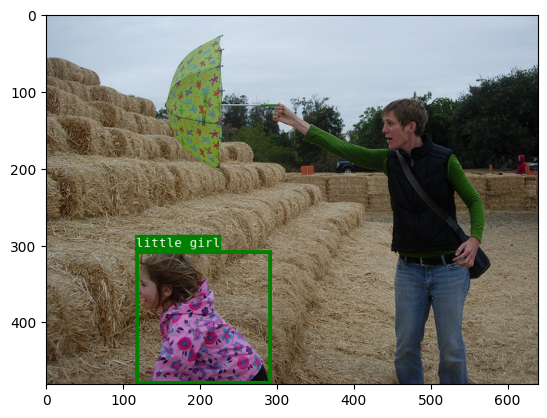

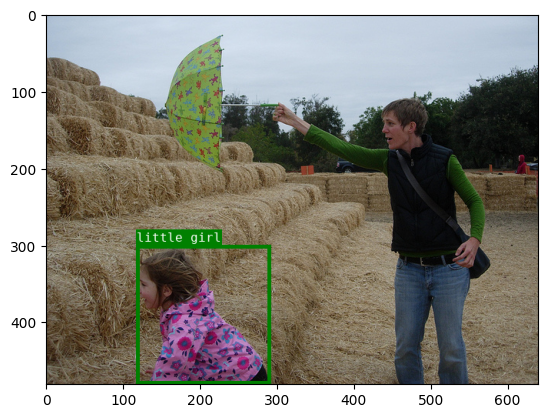

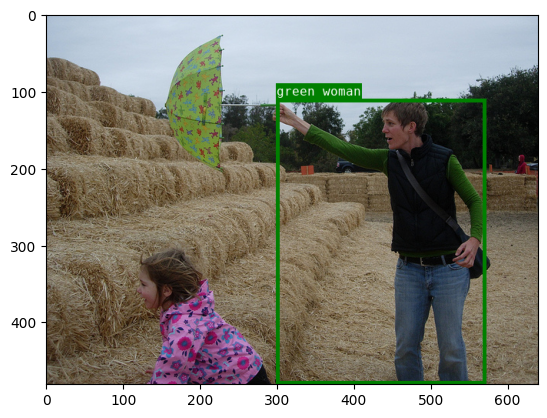

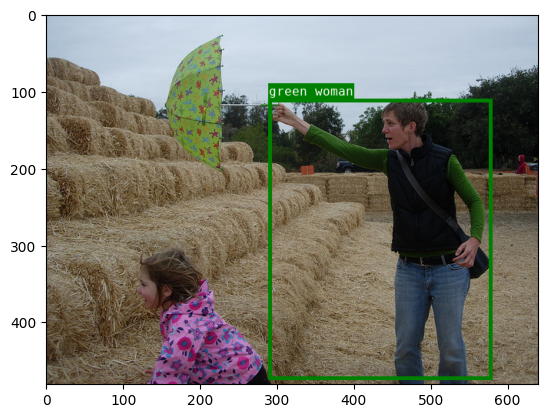

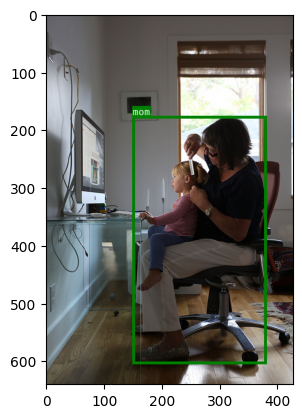

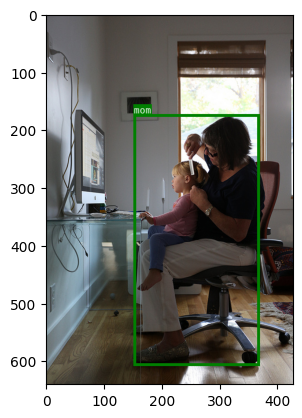

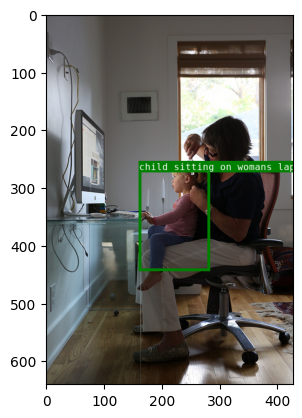

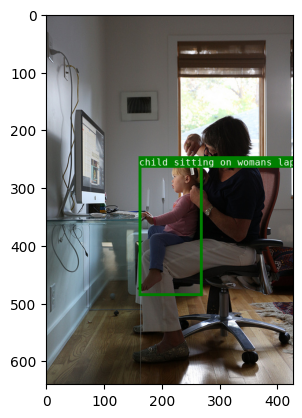

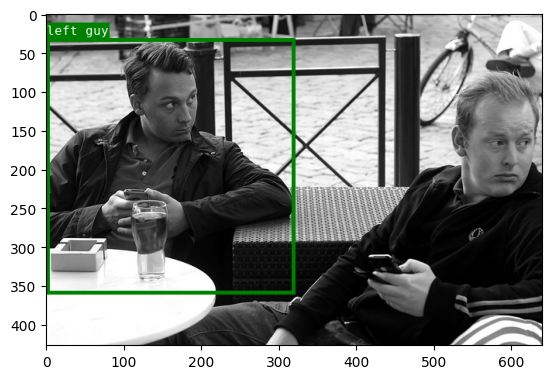

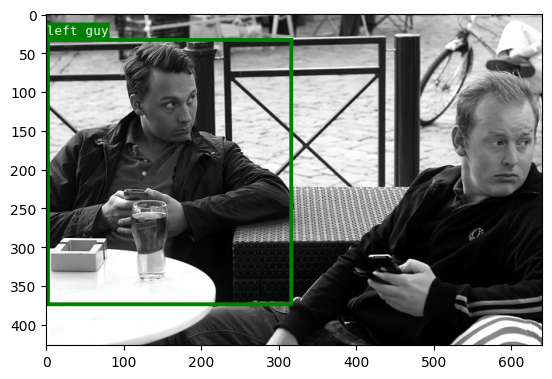

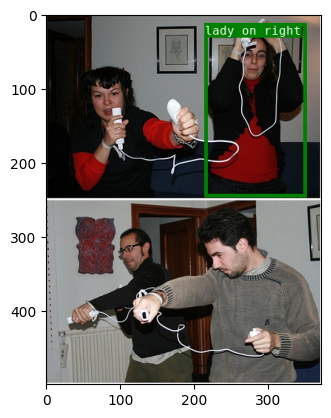

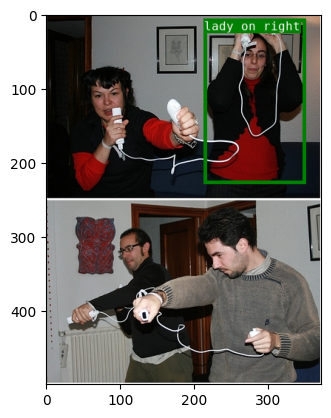

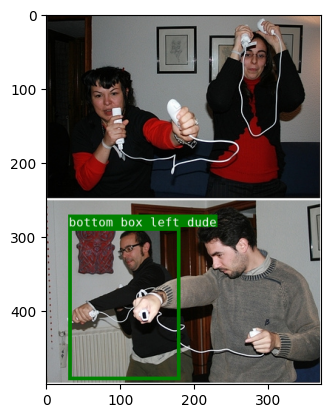

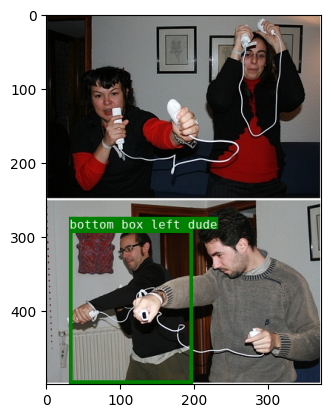

model_bbox_list[i] == False


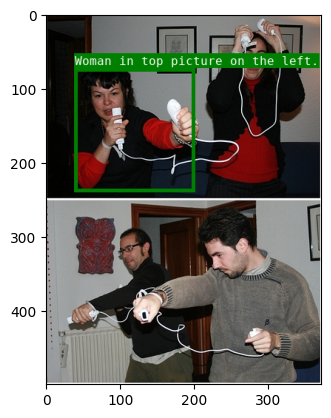

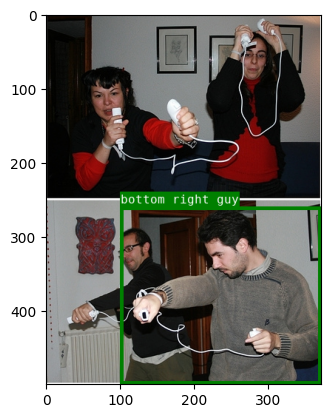

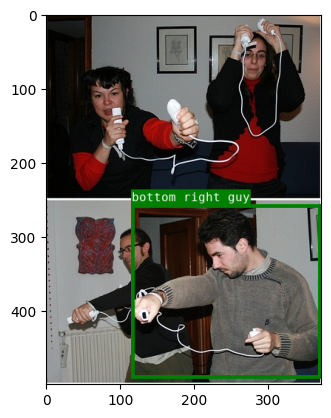

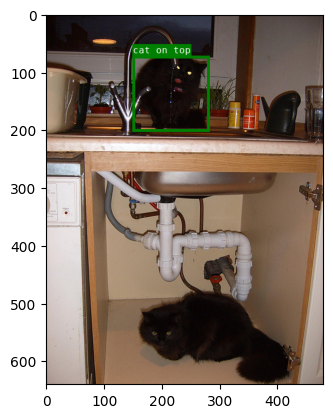

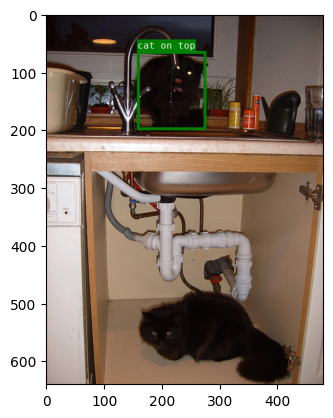

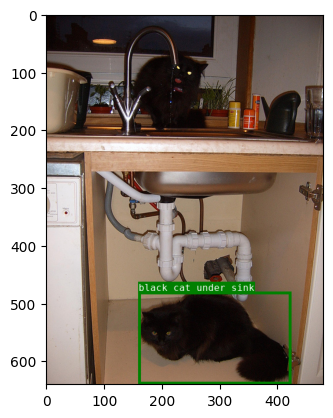

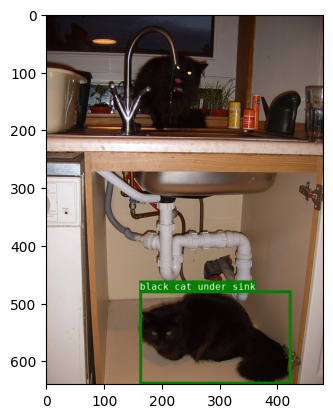

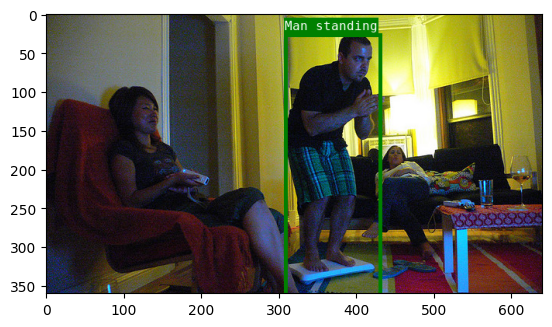

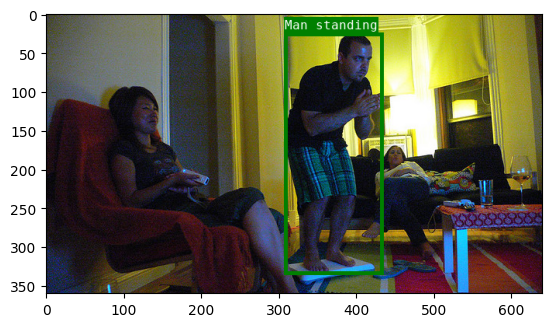

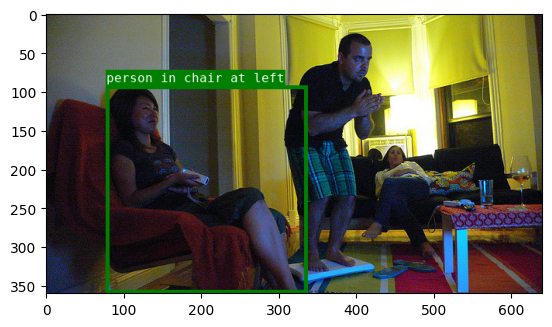

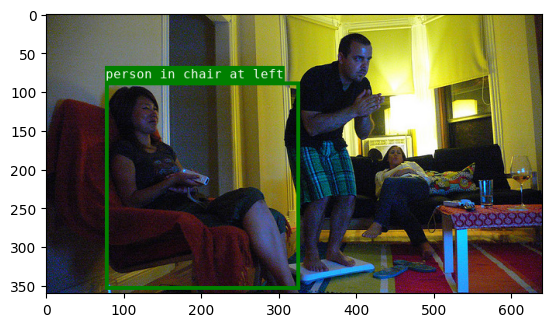

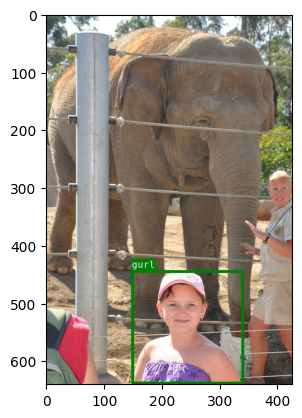

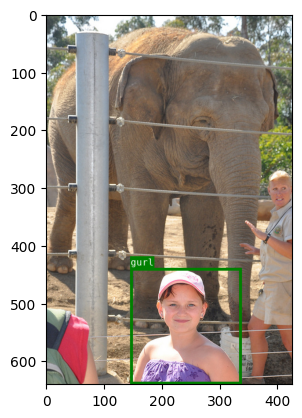

In [20]:
for i in range(len(image_list)):
    if model_bbox_list[i] == False:
        print("model_bbox_list[i] == False")
    else:
        visualize_bbox(image_list[i], model_bbox_list[i], caption_list[i],original_image_width_height_list[i])
    visualize_bbox(image_list[i], gt_bbox_list[i], caption_list[i],original_image_width_height_list[i])

In [10]:
print(generated_text[8])

 addCriterion("bottom box left dude", {"bbox_2d": [30, 291, 178, 498], "label": "bottom box left dude"})
<|im_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [ ]:
messages = [
    {
        "role": "user",
        "content": [

            # {"type": "text", "text": "Please output bbox coordinates and names of every object in this image in JSON format"},
            {"type": "text", "text": "Locate \"The creature on the left side of the woman\", report the bbox coordinates in JSON format."},
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)


In [ ]:
print(text)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Locate "The creature on the left side of the woman", report the bbox coordinates in JSON format.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant



In [ ]:
image_inputs, video_inputs = process_vision_info(messages)
print(image_inputs)
print(video_inputs)

[<PIL.Image.Image image mode=RGB size=2044x1372 at 0x153DABBC76E0>]
None


In [ ]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda:0")
print(inputs)


{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0.8501,  0.8501,  0.8647,  ...,  1.3922,  1.3922,  1.3922],
        [ 0.9376,  0.9376,  0.9376,  ...,  1.4491,  1.4491,  1.4491],
        [ 0.9084,  0.9376,  0.9376,  ...,  1.4065,  1.4207,  1.4207],
        ...,
        [-0.1280, -0.1280, -0.1426,  ..., -0.2431, -0.2715, -0.3000],
        [-0.3324, -0.3324, -0.3032,  ..., -0.3000, -0.2715, -0.2857],
        [-0.3762, -0.4054, -0.4054,  ..., -0.4279, -0.4422, -0.4564]],
       device='cuda:0'), 'image_grid_thw': tensor([[  1,  98, 146]], device='cuda:0')}


In [ ]:



# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=False, clean_up_tokenization_spaces=False
)
print(output_text)

['```json\n[\n\t{"bbox_2d": [458, 586, 1190, 1213], "label": "The creature on the left side of the woman"}\n]\n```<|im_end|>']


In [ ]:
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

In [ ]:
vocab = processor.tokenizer.get_vocab()

In [ ]:
print(len(vocab))

151665


In [ ]:
print(vocab["<|box_start|>"])

151648


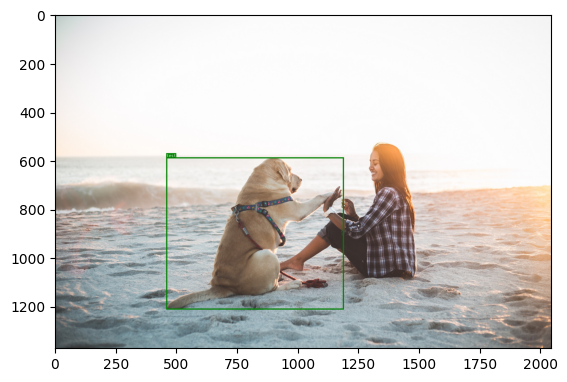

In [ ]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
def visualize_bbox(image, bbox, caption):
    bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()
    
visualize_bbox(image_inputs[0], [458, 586, 1190, 1213], "test")

In [ ]:
from PIL import Image
original_image = Image.open("../demo.jpeg")
print(original_image.size)
print(image_inputs[0].size)

(2048, 1365)
(2044, 1372)
